# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdrobust import rdplot
from rdrobust import rdrobust
from plotnine import *

# Methods

Methods for Identification 

In [2]:
def sign(x):
    """
    This function computes the sign of the given observation.

    Parameters
    ----------
    x : int
        The observation to compute the sign.

    Returns
    -------
    sign: int 
        Returns -1 if x is negative and 1 if nonnegative.
    """
    if x<0:
        return -1
    else:
        return 1

def treatment(x):
    """
    This function computes if an observation has received treatment.

    Parameters
    ----------
    x : int
        The observation to compute the treatment variable.

    Returns
    -------
    treatment: int 
        Returns 0 if observation x does not receive treatment and 1 if it does receive treatment.
    """
    if x<0:
        return 0
    else:
        return 1

def indicator(x):
    """
    This indicator function computes if an observation is within a distance of the threshold.

    Parameters
    ----------
    x : int
        The observation to compute the indicator value.

    Returns
    -------
    treatment: int 
        Returns 1 if observation x is within the distance and 0 if it is not.
    """
    if np.abs(x)<0.1:
        return 1
    else:
        return 0


def genT(X):
    """
    This function creates an array of treatment variables for a sample of observations.

    Parameters
    ----------
    X : arrray[int]
        The sample of observation to compute the treatment values for.

    Returns
    -------
    T: array[int]
        Returns an array with 1's and 0's for each observation depending on wether that observation received treatment.
    """
    T = {}
    for i in range(len(X)):
        T = np.append(T,treatment(X[i]))
    T = np.delete(T,0)
    return T
            


Methods for Generation of Outcomes: $Y_{i} = \mu(X_{i}) + \varepsilon_i$

$Y_{i}$ from Noak and Rothe 2023 donut RDD paper: 
$\newline \mu_N(x)=sign(x)*x^2-L*sign(x)((x-\delta*sign(x))^2-\delta^2*sign(x))*\boldsymbol{1}\{|x|<\delta\}$

In [3]:
def mu_noak(L,x):
    """
    This function generates the non-random part of outcome function with the DGP used by Noack and Rothe (NR) (2023).

    Parameters
    ----------
    L : int
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}.
    x : int
        The observation to compute the non-random outcome value for.

    Returns
    -------
    mu: int
        Returns the non-random part of the outcome value for that observation.
    """
    return sign(x)*np.power(x,2) - L*sign(x)*(np.power(x-0.1*sign(x),2)-np.power(0.1,2)*sign(x))*indicator(x)

def genY_noak(L,X,epsilon):
    """
    This function generates a sample of outcomes (Y_i's) with the DGP used by Noack and Rothe (NR) (2023).

    Parameters
    ----------
    L : int
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}.
    X : arrray[int]
        The sample of observation to compute the outcome values for.
    epsilon : arrray[int]
        The vector of random errors.

    Returns
    -------
    Y: arrray[int]
        Returns a vector with the outcome values.
    """
    Y = {}
    for i in range(len(X)):
        Y = np.append(Y,mu_noak(L,X[i]) + epsilon[i])
    Y = np.delete(Y,0)
    return Y

Basic linear outcomes ($Y_{i}$) plus simple treatment effect: $\quad \mu_{BL}(x)= \alpha + \beta x + \tau t$

In [5]:
def mu_basicLinear(tau,alpha,beta,x): 
    """
    This function generates the non-random part of the outcome function with a basic linear potential outcomes framework DGP.

    Parameters
    ----------
    tau : int 
        The size of the treatment effect.
    alpha: int
        The intercept parameter of the equation.
    beta: int
        The slope parameter of the equation.
    x : int
        The observation to compute the non-random outcome value for.

    Returns
    -------
    mu: int
        Returns the non-random part the outcome value.
    """
    return alpha + beta*x + tau*treatment(x)

def genY_basicLinear(tau,alpha,beta,X,epsilon):
    """
    This function generates a sample of outcomes (Y_i's) with a basic linear potential outcomes framework DGP.

    Parameters
    ----------
    tau : int 
        The size of the treatment effect.
    alpha: int
        The intercept parameter of the equation.
    beta: int
        The slope parameter of the equation.
    X : arrray[int]
        The sample of observation to compute the outcome values for.
    epsilon : arrray[int]
        The vector of random errors.

    Returns
    -------
    Y: arrray[int]
        Returns a vector with the outcome values.
    """
    Y = {}
    for i in range(len(X)):
        Y = np.append(Y,mu_basicLinear(tau,alpha,beta,X[i]) + epsilon[i])
    Y = np.delete(Y,0)
    return Y

# Sample Generation 

Seed Set-up

In [6]:
sd = np.random.default_rng(seed=42)
print(sd)

Generator(PCG64)


Generation of the Outcomes ($Y_{i}$) given the different DGP's

In [7]:
def genY(name, X, tau=0, L=0, alpha=0, beta=0):
    """
    This function generates a sample of observations from the given DGP.

    Parameters
    ----------
    name: string
        The name of the DGP to use.
    X : arrray[int]
        The sample of observation to compute the outcome values for.
    tau : int, Default value: 0
        The size of the treatment effect. For basic and basic linear model.
    L : int, Default value: 0
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}. For the Noack and Rothe model.
    alpha: int, Default value: 0
        The intercept parameter of the equation. For basic linear model.
    beta: int, Default value: 0
        The slope parameter of the equation. For basic linear model.

    Returns
    -------
    Y: arrray[int]
        Returns a vector with the outcome values.
    """
    epsilon = np.random.normal(0,0.5,len(X))
    if name == 'Noack':
        Y = genY_noak(L,X,epsilon)
    elif name == 'Basic':
        Y = genY_basic(tau,X,epsilon)
    elif name == 'Basic Linear':
        Y = genY_basicLinear(tau,alpha,beta,X,epsilon)
    else:
        return NameError('Type of GDP is not recognised')
    return Y

Generation os the Sample $X_i$'s and $Y_i$'s

In [8]:

def genSample(name, n, tau=0, L=0, alpha=0, beta=0, printPlot=True):
    """
    Generate a sample for RDD analysis: running variables (X), outcomes (Y), and treatments (T)

    Parameters
    ----------
    name: string, Options: 'Noak', 'Basic', 'Basic Linear'
        The name of the DGP to use to generate the sample.
    n: int
        The size of the sample.
    tau : int, Default value: 0
        The size of the treatment effect. For basic and basic linear model.
    L : int, Default value: 0
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}. For the Noack and Rothe model.
    alpha: int, Default value: 0
        The intercept parameter of the equation. For basic linear model.
    beta: int, Default value: 0
        The slope parameter of the equation. For basic linear model.
    printPlot: boolean, Default value: False
        Defines if a plot is printed with the sample.

    Returns
    -------
    sample: DataFrame
        A dataframe object with the geneated Y (outcomes) and X (running variables) and given T (treatment variables)
    """
    X = np.random.uniform(-1,1,n)
    Y = genY(name, X, tau, L, alpha, beta)
    T = genT(X)

    # Create sample dataframe
    sample = pd.DataFrame({'Y': Y,'X': X,'T': T})
    sample.Y = sample.Y.astype(float)

    # Print plot
    if printPlot == True:
        plt.scatter(X,Y,s=6)
        plt.xlabel('$X_i$')
        plt.ylabel('$Y_i$')
        
    return sample

Test Generate Sample Command

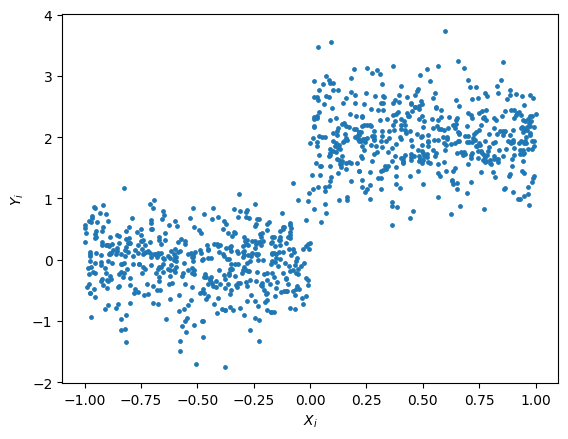

In [9]:
# Options are: 'Noak', 'Basic', 'Basic Linear'
sample = genSample('Basic',1000,2,printPlot=True)
#sample.to_csv('sample.csv')

In [10]:
rdrobust(sample.Y,sample.X,p=1)

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           497        503
Number of Unique Obs.            497        503
Number of Effective Obs.         212        201
Bandwidth Estimation            0.39       0.39
Bandwidth Bias                 0.602      0.602
rho (h/b)                      0.647      0.647

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional        1.96    0.128   15.367   2.719e-53       [1.71, 2.21]
Robust                 -        -   12.876   6.106e-38     [1.681, 2.284]


# Simulation of Treatment Effects Estimation

c:\Users\Francisco\AppData\Local\Programs\Python\Python312\Lib\site-packages\rdrobust\rdplot.py:743: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


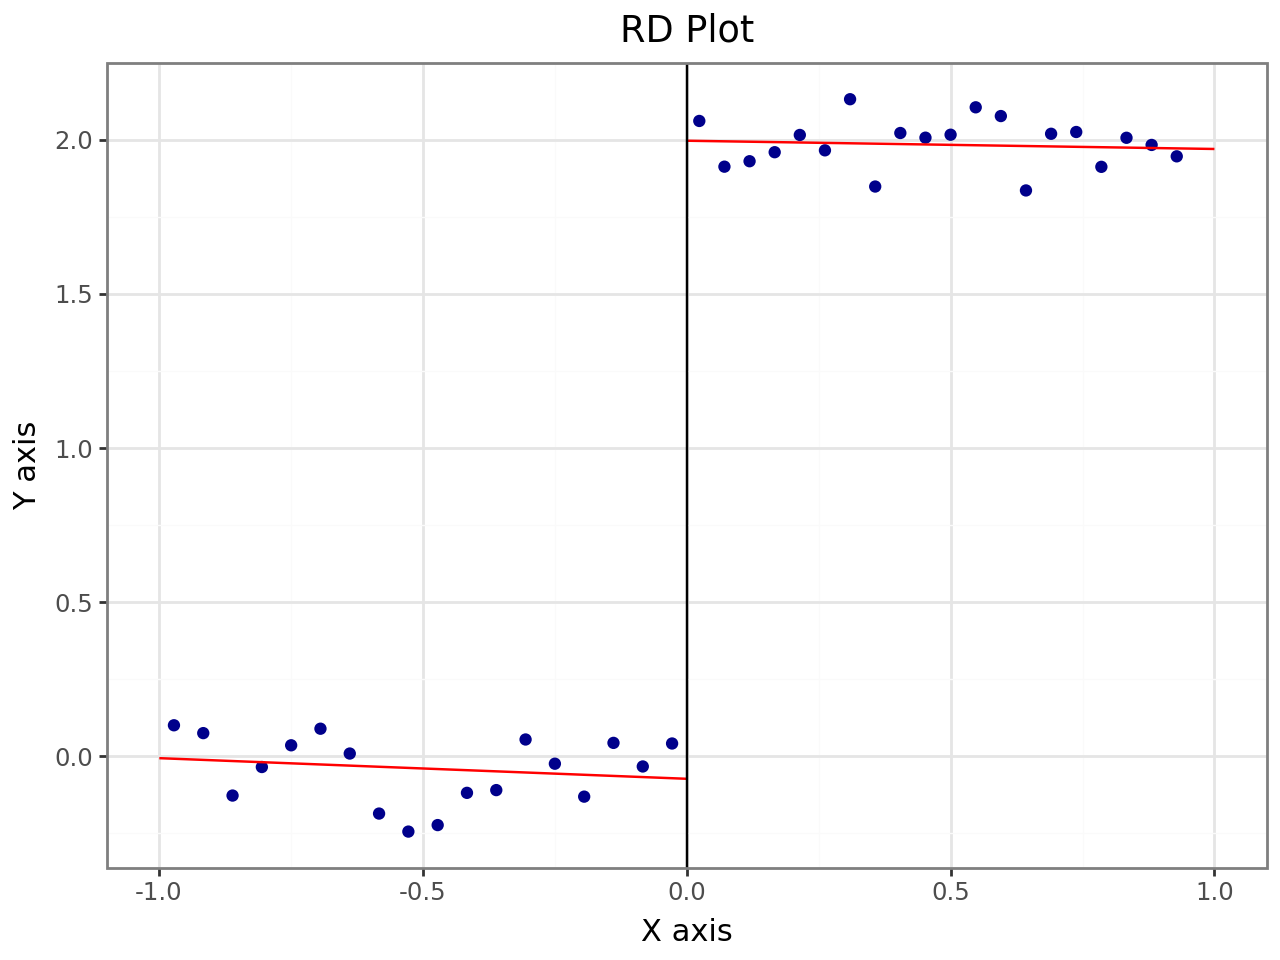


Call: rdplot
Number of Observations:                  1000
Kernel:                               Uniform
Polynomial Order Est. (p):                  1

                                Left      Right
------------------------------------------------
Number of Observations           497        503
Number of Effective Obs          497        503
Bandwith poly. fit (h)         0.999        1.0
Number of bins scale               1          1
Bins Selected                     18         21
Average Bin Length             0.056      0.048
Median Bin Length              0.056      0.048
IMSE-optimal bins                4.0        2.0
Mimicking Variance bins         18.0       21.0

Relative to IMSE-optimal:
Implied scale                    4.5       10.5
WIMSE variance weight          0.011      0.001
WIMSE bias weight              0.989      0.999


In [11]:
rdplot(sample.Y,sample.X,p=1)

In [12]:
n = 1000
L = np.array([0,10,20,30,40])
tau = 2
a = -1
b = 1

In [13]:
def simulation(name,n,r,tau=0, L=0, alpha=0, beta=0):
    """
    Run simulation analysis for RDD: Generates a sample r times and returns the results of each sample
    Parameters
    ----------
    name: string, Options: 'Noak', 'Basic', 'Basic Linear'
        The name of the DGP to use to generate the sample.
    n: int
        The size of the sample.
    r: int 
        The number of replications.
    tau : int , Default value: 0
        The size of the treatment effect. For basic and basic linear model.
    L : int, Default value: 0
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}. For the Noack and Rothe model.
    alpha: int, Default value: 0
        The intercept parameter of the equation. For basic linear model.
    beta: int, Default value: 0
        The slope parameter of the equation. For basic linear model.
   
    
    Returns
    -------
    sample: DataFrame
        A dataframe object with the results from the simulation. 
        For each smaple it returns the estimated Treatment Effects (TE), bandwidth (H).
    """ 
    TE = {}
    H_left = {}
    H_right ={}
    for i in range(r):
        sample = genSample(name,n,tau, L, alpha, beta, printPlot=False)
        res = rdrobust(sample.Y,sample.X)
        TE = np.append(TE, res.coef.iloc[0])
        H_left = np.append(H_left,res.bws.left.iloc[0])
        H_right = np.append(H_right,res.bws.right.iloc[0])
    TE = np.delete(TE,0)
    H_left = np.delete(H_left,0)
    H_right = np.delete(H_right,0)
    simulationResults = pd.DataFrame({'TE':TE,'H_left':H_left,'H_right':H_right})
    return simulationResults

In [19]:
simulationResults = simulation('Basic',1000,1000,2)

In [ ]:
np.mean(simulationResults.TE)

-0.5474825408193285

In [ ]:
np.std(simulationResults.TE)

0.47942690863635323

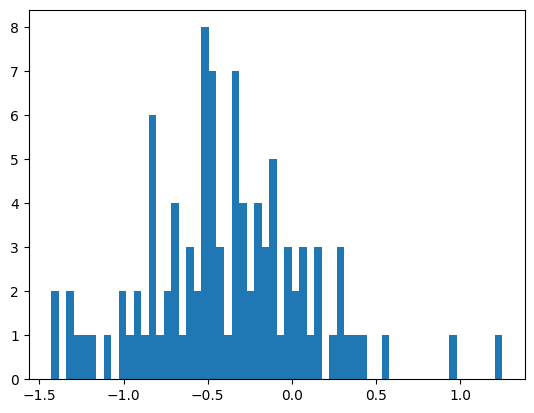

In [ ]:
hist = plt.hist(simulationResults.TE, bins=60)